# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-03 00:05:57 - xopt.generator - INFO - Initialized generator nsga2
2025-03-03 00:05:57 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-03 00:05:57 - xopt.base - INFO - Running Xopt step
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INFO - generated 50 candidates in 2.76ms (removed 0 duplicate individuals)
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INFO - adding 50 new evaluated individuals to generator
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INFO - completed generation 1 in 0.020s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-03 00:05:57 - xopt.base - INFO - Running Xopt step
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INFO - generated 50 candidates in 10.53ms (removed 0 duplicate individuals)
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INFO - adding 50 new evaluated individuals to generator
2025-03-03 00:05:57 - xopt.generators.ga.nsga2.NSGA2Generator.2204589238992 - INF

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 797 ms
Wall time: 908 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.005890,0.913088,0.203249,0.883200,0.341023,0.577136,0.468847,0.058574,0.939766,0.925363,...,0.696883,0.625258,0.337121,0,37,0.005890,5.008355,5.184185,0.000039,False
1,0.017540,0.079089,0.867697,0.716819,0.475615,0.720856,0.376494,0.282993,0.970185,0.848160,...,0.260798,0.806095,0.511898,0,36,0.017540,5.714985,6.049924,0.000013,False
2,0.030136,0.812414,0.380368,0.743033,0.247420,0.264865,0.339190,0.757126,0.373161,0.780864,...,0.270661,0.654568,0.156812,0,48,0.030136,5.489742,5.937189,0.000010,False
3,0.046120,0.997208,0.989656,0.993397,0.946928,0.883312,0.618634,0.951083,0.052423,0.025572,...,0.908076,0.954415,0.448542,0,39,0.046120,5.269726,5.834226,0.000009,False
4,0.050549,0.487005,0.953735,0.071200,0.917632,0.797461,0.018886,0.828725,0.881863,0.246675,...,0.801350,0.494822,0.350536,0,26,0.050549,5.266822,5.861700,0.000008,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2475, 2455, 2450, 2401, 2254, 2467, 2488, 2468, 2402, 2473, 2485, 2421, 2429, 2395, 2456, 2391]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.005890,0.913088,0.203249,0.883200,0.341023,0.577136,0.468847,0.058574,0.939766,0.925363,...,0.696883,0.625258,0.337121,0,37,0.005890,5.008355,5.184185,0.000039,False
1,0.017540,0.079089,0.867697,0.716819,0.475615,0.720856,0.376494,0.282993,0.970185,0.848160,...,0.260798,0.806095,0.511898,0,36,0.017540,5.714985,6.049924,0.000013,False
2,0.030136,0.812414,0.380368,0.743033,0.247420,0.264865,0.339190,0.757126,0.373161,0.780864,...,0.270661,0.654568,0.156812,0,48,0.030136,5.489742,5.937189,0.000010,False
3,0.046120,0.997208,0.989656,0.993397,0.946928,0.883312,0.618634,0.951083,0.052423,0.025572,...,0.908076,0.954415,0.448542,0,39,0.046120,5.269726,5.834226,0.000009,False
4,0.050549,0.487005,0.953735,0.071200,0.917632,0.797461,0.018886,0.828725,0.881863,0.246675,...,0.801350,0.494822,0.350536,0,26,0.050549,5.266822,5.861700,0.000008,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

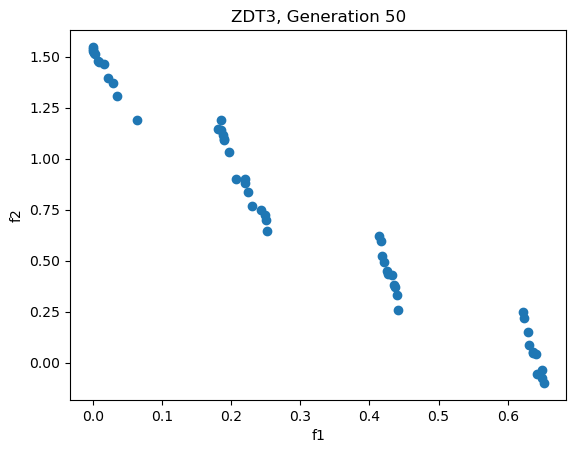

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory
 - `log.txt`: Log output from the generator is recorded to this file

 Wile running each of the blocks, go ahead and open the temporary directory printed from the next cell and take a look at the files for yourself.

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpbf7n90i7"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # Turn on checkpoints and set ow often (in terms of generations) we save the optimizer state
    log_level=logging.DEBUG,  # Set the level of log messages output to our log file
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpbf7n90i7": ['checkpoints', 'data.csv', 'log.txt', 'populations.csv', 'vocs.txt']
"checkpoints": ['20250303_000558_1.txt', '20250303_000558_2.txt', '20250303_000559_1.txt', '20250303_000559_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

# Clean up the directory
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpbf7n90i7"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpbf7n90i7_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.056649,0.666156,0.992821,0.695115,0.045048,0.307589,0.674919,0.306287,0.271246,0.254925,...,0.574518,0.601530,0.017232,0,31,0.056649,5.350698,5.988567,0.000031,False
1,0.058800,0.912236,0.282839,0.488041,0.788642,0.256999,0.099322,0.850822,0.649644,0.845985,...,0.807376,0.304648,0.994357,0,21,0.058800,5.062004,5.697365,0.000010,False
2,0.059824,0.788794,0.105771,0.555470,0.689399,0.285304,0.323397,0.468873,0.450599,0.795923,...,0.762710,0.419598,0.866016,0,47,0.059824,4.404359,5.008753,0.000009,False
3,0.060205,0.205658,0.218360,0.026928,0.222574,0.768761,0.503462,0.149917,0.279965,0.760288,...,0.975678,0.105198,0.060217,0,5,0.060205,4.476817,5.087388,0.000008,False
4,0.083550,0.086002,0.544227,0.058593,0.298244,0.615798,0.971473,0.793684,0.881143,0.406469,...,0.328271,0.983516,0.275578,0,36,0.083550,5.150762,5.893774,0.000008,False


In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.846494,0.012445,0.096174,0.036246,0.034928,0.026954,0.034609,0.015688,0.088965,0.017616,...,0.030683,0.107053,31,1593,0.846494,-0.121764,2.030693,0.000008,False,32
1551,0.000458,0.019037,0.131812,0.087403,0.031564,0.006768,0.143275,0.023750,0.089156,0.038259,...,0.004254,0.114901,30,1506,0.000458,2.060343,2.091302,0.000027,False,32
1552,0.248478,0.023025,0.105319,0.139205,0.117813,0.038971,0.035772,0.129186,0.289145,0.011492,...,0.010981,0.115726,31,1565,0.248478,1.249009,2.243901,0.000008,False,32
1553,0.089288,0.006850,0.095113,0.032840,0.120196,0.004884,0.041408,0.015600,0.091724,0.011414,...,0.011046,0.115473,31,1594,0.089288,1.573338,2.028394,0.000008,False,32
1554,0.259584,0.006129,0.087455,0.125521,0.065204,0.007357,0.035970,0.036928,0.259775,0.036494,...,0.032779,0.125034,31,1584,0.259584,1.059802,2.034413,0.000008,False,32


In [18]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [ ]:
# Clean up the original output
generator.close_log_file()
shutil.rmtree(output_dir)